# Available Nested Samplers

Most nested sampling libraries require two things to generate samples from a posterior distribution:

1. A prior transform converting samples from a uniform distribution to the prior distribution
2. A log-likelihood function

RadVel's `Posterior` object implements both of these through `Posterior.prior_transform()` and `Posterior.likelihood_ns_array()`.
This means models defined with RadVel can be sampled using pretty much any nested sampling library.
For convenience, a few of them have wrappers implemented in the `radvel.nested_sampling` module:

- [UltraNest](https://johannesbuchner.github.io/UltraNest/index.html)
- [dynesty](https://dynesty.readthedocs.io/)
- [PyMultiNest](https://github.com/JohannesBuchner/PyMultiNest/)
- [Nautilus](https://nautilus-sampler.readthedocs.io/)

While these libraries all have a similar APIs, there are small differences in how they should be run and how they generate their outputs.
The `radvel.nested_sampling` module provides a common output format for all libraries, as explained below.

In this notebook, we will demonstrate how to sample a RadVel model with each of these libraries using the K2-24 example dataset from the [K2-24 Fitting & MCMC tutorial](https://radvel.readthedocs.io/en/latest/tutorials/K2-24_Fitting+MCMC.htm)

## Model Definition

First, we need to set up the RadVel model as we would do for MCMC.

In [1]:
import time

import radvel
import numpy as np
from pandas import read_csv
import os
from radvel import nested_sampling as rns

import matplotlib.pyplot as plt

/home/vandal/miniforge3/envs/radvel/lib/python3.10/site-packages/docutils/utils/code_analyzer.py:12: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound as ResourceError


In [2]:
# Set to True to avoid re-running samplers
RESUME = True
OVERWRITE = True

In [3]:
def initialize_model():
    time_base = 2420
    params = radvel.Parameters(2,basis='per tc secosw sesinw logk') # number of planets = 2
    params['per1'] = radvel.Parameter(value=20.885258)
    params['tc1'] = radvel.Parameter(value=2072.79438)
    params['secosw1'] = radvel.Parameter(value=0.01)
    params['sesinw1'] = radvel.Parameter(value=0.01)
    params['logk1'] = radvel.Parameter(value=1.1)
    params['per2'] = radvel.Parameter(value=42.363011)
    params['tc2'] = radvel.Parameter(value=2082.62516)
    params['secosw2'] = radvel.Parameter(value=0.01)
    params['sesinw2'] = radvel.Parameter(value=0.01)
    params['logk2'] = radvel.Parameter(value=1.1)
    mod = radvel.RVModel(params, time_base=time_base)
    mod.params['dvdt'] = radvel.Parameter(value=-0.02)
    mod.params['curv'] = radvel.Parameter(value=0.01)

    like = radvel.likelihood.RVLikelihood(mod, t, vel, errvel)
    like.params['gamma'] = radvel.Parameter(value=0.1, vary=False, linear=True)
    like.params['jit'] = radvel.Parameter(value=1.0)
    like.params['secosw1'].vary = False
    like.params['sesinw1'].vary = False
    like.params['per1'].vary = False
    like.params['tc1'].vary = False
    like.params['secosw2'].vary = False
    like.params['sesinw2'].vary = False
    like.params['per2'].vary = False
    like.params['tc2'].vary = False

    post = radvel.posterior.Posterior(like)
    post.priors += [radvel.prior.Gaussian('jit', np.log(3), 0.5)]
    post.priors += [radvel.prior.Gaussian('logk1', np.log(5), 10)]
    post.priors += [radvel.prior.Gaussian('dvdt', 0, 1.0)]
    post.priors += [radvel.prior.Gaussian('curv', 0, 1e-1)]
    post.priors += [radvel.prior.Gaussian('logk2', np.log(5), 10)]

    return post

In [4]:
path = os.path.join(radvel.DATADIR,'epic203771098.csv')
rv = read_csv(path)

t = np.array(rv.t)
vel = np.array(rv.vel)
errvel = rv.errvel
ti = np.linspace(rv.t.iloc[0]-5,rv.t.iloc[-1]+5,100)

In [5]:
post = initialize_model()
print(post)

parameter                     value      vary
per1                        20.8853      False
tc1                         2072.79      False
secosw1                        0.01      False
sesinw1                        0.01      False
logk1                           1.1       True
per2                         42.363      False
tc2                         2082.63      False
secosw2                        0.01      False
sesinw2                        0.01      False
logk2                           1.1       True
dvdt                          -0.02       True
curv                           0.01       True
gamma                           0.1      False
jit                               1       True
tp1                         2070.18           
e1                           0.0002           
w1                         0.785398           
k1                          3.00417           
tp2                         2077.33           
e2                           0.0002           
w2            

In [6]:
def plot_results(like):
    fig = plt.figure(figsize=(12,4))
    fig = plt.gcf()
    fig.set_tight_layout(True)
    plt.errorbar(
        like.x, like.model(t)+like.residuals(), 
        yerr=like.yerr, fmt='o'
        )
    plt.plot(ti, like.model(ti))
    plt.xlabel('Time')
    plt.ylabel('RV')
    return fig

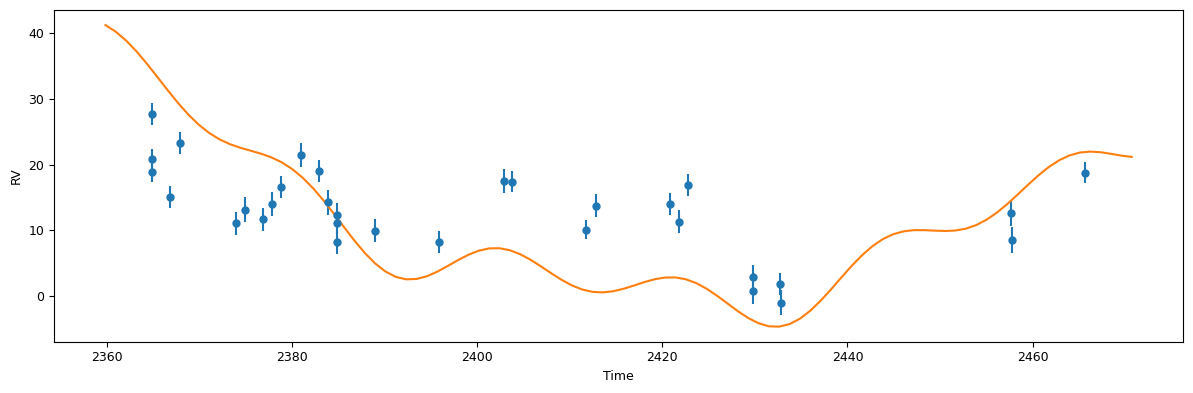

In [7]:
plot_results(post.likelihood)
plt.show()

## Nested Sampling

Now that we have our model, we can run one or more nested sampling algorithms.
Here we run all libraries available in RadVel.
Each library has its own `nested_sampling.run_<library_name>()` methods.

In their simplest form, all these methods require only a `Posterior` as input.
However, arguments can be passed directly to the samplers or the "run" functions through `sampler_kwargs` and `run_kwargs`, respectively.
We refer users to the documentation of each library (linked at the start of this notebook) to find out which arguments are available.

Each nested sampling function will return results in a standard dictionary format with the following keys:

- `samples`: _equally-weighted_ samples (equivalent to MCMC samples)
- `lnZ`: Natural log of the Bayesian evidence
- `lnZerr`: Statistical uncertainty on the evidence
- `sampler`: Sampler object from the underlying nested sampling package, providing acces to more details about the run and its extra outputs. This is not available for PyMultiNest, which stores the outputs on disk instead of in a Python object.

## Running the samplers

Let us now run all available samplers and see how they perform.


In [9]:
multinest_start = time.time()
multinest_results = rns.run(post, sampler="multinest", output_dir="multinest_demo", run_kwargs={"resume": RESUME}, overwrite=OVERWRITE)
multinest_time = time.time() - multinest_start
print(f"Running multinest took {multinest_time / 60:.2f} min")

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    5
 *****************************************************
  analysing data from multinest_demo/out.txt ln(ev)=  -102.26092544689736      +/-  0.20493770861089861     
 Total Likelihood Evaluations:        23320
 Sampling finished. Exiting MultiNest

Running multinest took 0.52 min


In [10]:
dynesty_start = time.time()
dynesty_results = rns.run(post, sampler="dynesty-static", output_dir="dynesty_demo", run_kwargs={"resume": RESUME}, overwrite=OVERWRITE)
dynesty_time = time.time() - dynesty_start
print(f"Running dynesty took {dynesty_time / 60:.2f} min")

iter: 10555 | +500 | bound: 3266 | nc: 1 | ncall: 2466917 | eff(%):  0.448 | loglstar:   -inf < -82.566 <    inf | logz: -103.032 +/-    nan | dlogz:  0.001 >  0.509                                 

Running dynesty took 48.85 min


In [11]:
dynesty_start = time.time()
dynesty_dynamic_results = rns.run(post, sampler="dynesty-dynamic", output_dir="dynesty_demo_dynamic", run_kwargs={"resume": RESUME}, overwrite=OVERWRITE)
dynesty_time = time.time() - dynesty_start
print(f"Running dynesty took {dynesty_time / 60:.2f} min")

iter: 21440 | batch: 5 | bound: 37 | nc: 1 | ncall: 1444655 | eff(%):  1.480 | loglstar: -89.292 < -82.505 < -83.772 | logz: -103.288 +/-  0.134 | stop:  0.812                                       

Running dynesty took 29.33 min


In [12]:
ultranest_start = time.time()
# Ultranest does not accept False for "resume"
ultranest_results = rns.run(post, sampler="ultranest", output_dir="ultranest_demo", sampler_kwargs={"resume": RESUME or "subfolder"}, overwrite=OVERWRITE)
ultranest_time = time.time() - ultranest_start
print(f"Running ultranest took {ultranest_time / 60:.2f} min")

Creating directory for new run ultranest_demo/run1
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-8e+01  4 [-82.8700..-82.8696]*| it/evals=10102/347568 eff=2.9098% N=400         0 0  
[ultranest] Likelihood function evaluations: 347586
[ultranest] Writing samples and results to disk ...
[ultranest] Writing samples and results to disk ... done
[ultranest]   logZ = -103.5 +- 0.1487
[ultranest] Effective samples strategy satisfied (ESS = 2673.0, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.05 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.15, need <0.5)
[ultranest]   logZ error budget: single: 0.21 bs:0.15 tail:0.01 total:0.15 required:<0.50
[ultranest] done iterating.
Running ultranest took 7.25 min


In [13]:
nautilus_start = time.time()
nautilus_results = rns.run(post, sampler="nautilus", output_dir="nautilus_demo", sampler_kwargs={"resume": RESUME}, run_kwargs={"verbose": True}, overwrite=OVERWRITE)
nautilus_time = time.time() - nautilus_start
print(f"Running nautilus took {nautilus_time / 60:.2f} min")

Starting the nautilus sampler...
Please report issues at github.com/johannesulf/nautilus.
Status    | Bounds | Ellipses | Networks | Calls    | f_live | N_eff | log Z    
Finished  | 36     | 1        | 4        | 81300    | N/A    | 19626 | -103.34  
Running nautilus took 8.07 min


Once we have all the results, we can compare the Bayesian evidence and the posterior distributions to make sure they are consistent between samplers.
Keep in mind that nested sampling algorithms will perform differently on different problems.
Both speed and accuracy will depend on the number of dimensions (parameters) and the exact choice of settings.
See [Buchner (2021)](https://arxiv.org/abs/2101.09675) for a review of this topic.

In [14]:
print(f"Multinest: {multinest_results['lnZ']:.2f} +/- {multinest_results['lnZerr']:.2f}")
print(f"Dynesty (static): {dynesty_results['lnZ']:.2f} +/- {dynesty_results['lnZerr']:.2f}")
print(f"Dynesty (dynamic): {dynesty_dynamic_results['lnZ']:.2f} +/- {dynesty_dynamic_results['lnZerr']:.2f}")
print(f"Ultranest: {ultranest_results['lnZ']:.2f} +/- {ultranest_results['lnZerr']:.2f}")
print(f"Nautilus: {nautilus_results['lnZ']:.2f} +/- {nautilus_results['lnZerr']:.2f}")

Multinest: -103.33 +/- 0.04
Dynesty (static): -103.03 +/- 0.34
Dynesty (dynamic): -103.30 +/- 0.12
Ultranest: -103.39 +/- 0.22
Nautilus: -103.34 +/- 0.01


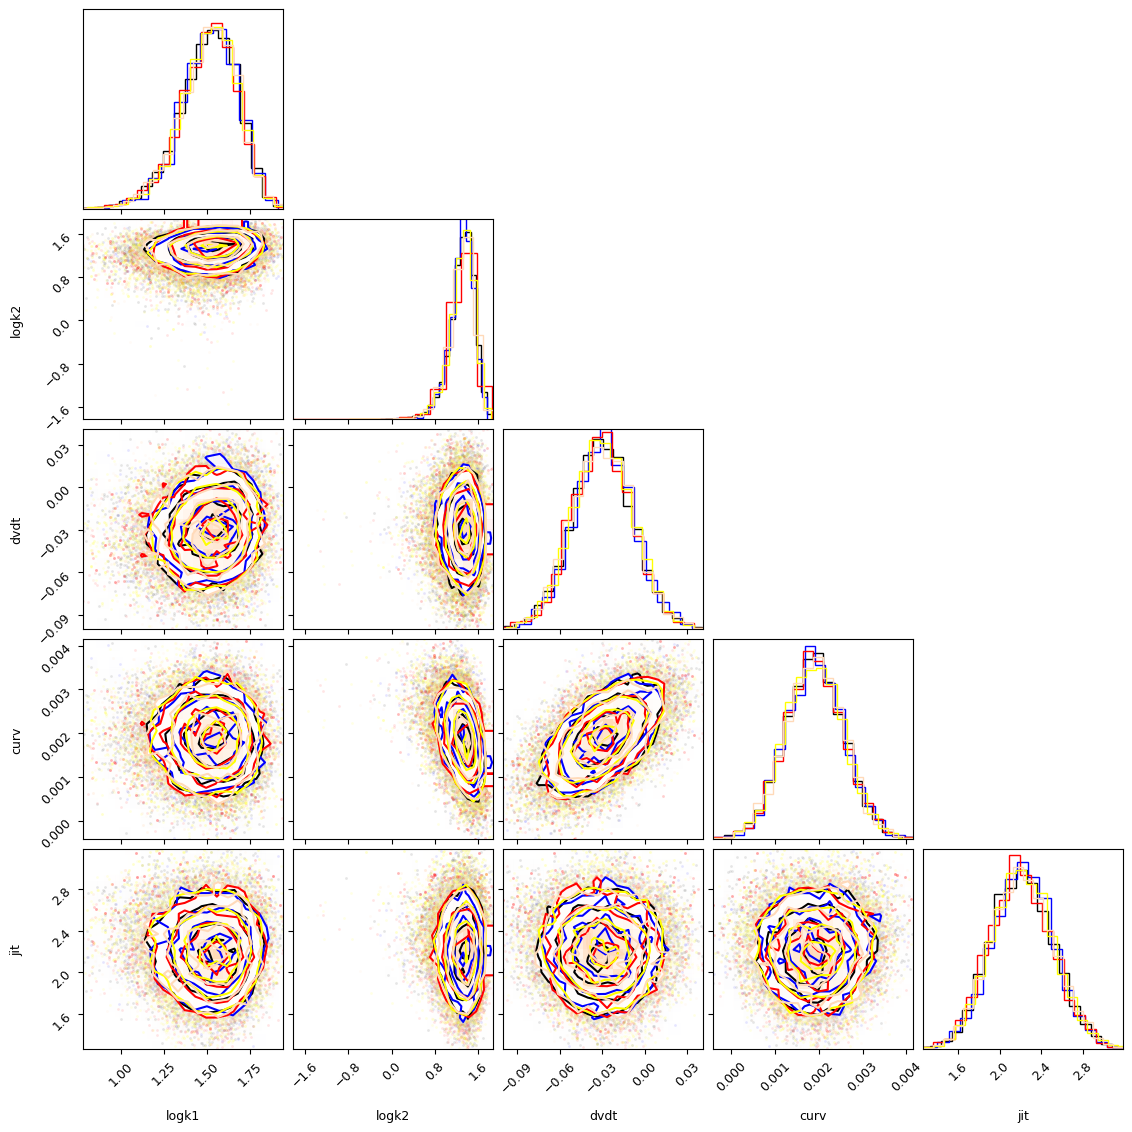

In [16]:
import corner

hist_kwargs = {"density": True}
fig = corner.corner(nautilus_results["samples"].values[:, :-1], labels=post.name_vary_params(),range=np.repeat(0.999, len(post.name_vary_params())), hist_kwargs=hist_kwargs)

corner.corner(multinest_results["samples"].values[:, :-1], color="b", fig=fig, hist_kwargs=hist_kwargs | {"color": "b"})

corner.corner(dynesty_results["samples"].values[:, :-1], color="r", fig=fig, hist_kwargs=hist_kwargs | {"color": "r"},range=np.repeat(0.999, len(post.name_vary_params())))

corner.corner(dynesty_dynamic_results["samples"].values[:, :-1], color="yellow", fig=fig, hist_kwargs=hist_kwargs | {"color": "yellow"},range=np.repeat(0.999, len(post.name_vary_params())))

corner.corner(ultranest_results["samples"].values[:, :-1], color="peachpuff", fig=fig, hist_kwargs=hist_kwargs | {"color": "peachpuff"}, range=np.repeat(0.999, len(post.name_vary_params())))

plt.show()